In [1]:
import numpy as np
import pandas as pd
import skimage.io
import os

import matplotlib.pyplot as plt
%matplotlib inline

### Functions from nucleus segmentation competition that will help here

In [2]:
### This just gets rid of any problem files that MacOSX tends to put in for its own book keeping
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

### Support function to grab the dimensions of an image or mask
def get_image_dim(image_path):
    return skimage.io.imread(image_path).shape

In [3]:
def IoU(x,y):
    '''
    version of IoU that uses np.bincount to get the value counts
    
    x and y are both numpy N x M masks
    
    x = proposed mask
    y = ground truth mask
    
    0 for a pixel indicates the mask is blocked, 1 indicates the mask is not blocked.
    In plain English, everywhere that is 1 we can see the cell, everywhere that is 0 we cannot.
    
    We want to calculate the IoU statistic, which is intersection(x,y)/union(x,y) at values where x or y is 1 
    
    By subtracting the proposed mask from 2 x the ground truth mask (i.e. blocked is 0, not blocked is 2),
    then adding 1, we get unique values for each type of overlap situation, plus all values are positive, which
    is required to use np.bincount:
    
INDX  0  1  2  3  4  5  6  7  8  9 10 11

GT    0  0  0  2  2  2  2  2  0  0  0  0
MSK - 0  0  1  1  1  1  0  1  1  0  0  0  
      ----------------------------------
      0  0 -1  1  1  1  2  1 -1  0  0  0
    + 1  1  1  1  1  1  1  1  1  1  1  1
      ----------------------------------
      1  1  0  2  2  2  3  2  0  1  1  1
      
    0: the proposed mask had a pixel, ground truth did not (include in union)   
    1: neither mask had a pixel (don't include)
    2: the proposed mask had a pixed, the ground truth had a pixel (include in intersection and union)
    3: the proposed mask did not have a pixel, the ground truth did (include in union)
    
    np.bincount always has length of np.amax(x) + 1, so we just need to do length checking
    '''
    x = x
    y = y * 2
    
    diff = np.bincount((y - x + 1).flatten())
    diff_len = len(diff)
    
    ### Cacluate the intersection first
    intersection = 0
    if (diff_len >= 3):
        intersection = diff[2]
    
    ### Now calculate the union
    union = intersection
    if diff_len == 4:
        union += diff[3]
    union += diff[0]
        
    if union==0:
        iou = 0 ### default value, we could potentially return blank masks, although GT should never be empty
    else:
        iou = float(intersection) / union
    
#     ### This is the code without error checking, basically doesn't speed it up at all
#     intersection = diff[2]
#     union = diff[0] + diff[2] + diff[3]
#     iou = float(intersection) / union

    return iou

def calc_IoU_matrix(gt_masks, pred_masks):
    '''
    Calculates the IoU matrix without thresholding. For increased speed, we could play some tricks based
    on the knowledge that 0.5 is the minimum threshold, but for now leaving out.
    
    Shape of gt_masks and pred_masks should be (num_masks, mask_x, mask_y)
    
    Returns a matrix with rows corresponding to ground truth masks, and columns predicted masks.
    '''
    ioumat = np.zeros((len(gt_masks),len(pred_masks)))
    for i in range(len(gt_masks)):
        for j in range(len(pred_masks)):
            ioumat[i,j] = IoU(pred_masks[j],gt_masks[i])
            
    return ioumat

def calc_precision(ioumat):
    '''
    Calculates the precision for a matrix that has already been thresholded.
    
    Assumes the minimum threshold is 0.5, i.e. all values <= 0.5 are eliminated. This helps
    us make some simplifying assumptions.
    '''
    ### First sum across the columns for each ground truth mask
    matsum = ioumat.sum(axis=1)
    
    true_pos = len(matsum[matsum > 0.0])
    false_neg = len(matsum[matsum == 0.0])
    false_pos = ioumat.shape[1] - true_pos
    
    precision = float(true_pos) / (true_pos + false_neg + false_pos)
    
    return precision#, true_pos, false_neg, false_pos

def calc_precisions(gt_masks, pred_masks, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    ### First calculate the IoU matrix
    ioumat = calc_IoU_matrix(gt_masks, pred_masks)
    
    precisions = []
    for threshold in thresholds:
        ioumat[ioumat <= threshold] = 0.0
        
        precisions.append(calc_precision(ioumat))
        
    return precisions

def calc_average_precision(gt_masks, pred_masks, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    precisions = np.array(calc_precisions(gt_masks, pred_masks, thresholds))
    return precisions.mean()

In [4]:
def load_img(basedir, imgid):
    imgname = imgid + '.png'
    
    ### Load in the test image
    img = skimage.io.imread(basedir + imgid + '/images/' + imgname)
    
    return img    

def load_masks(basedir, imgid):
    ### Grab the mask file names
    mask_files = filter_directory_list(os.listdir(basedir + imgid + "/masks"))
    
    ### Load in the masks for the test image
    masks = np.array([skimage.io.imread(basedir + imgid + '/masks/' + mask) for mask in mask_files])
    
    ### Scale down to a 0 to 1 scale, which is needed for fast IoU calculation
    masks = masks / 255
    
    return masks

In [5]:
def create_circle_mask(imgshape, y, x, r):
    mask = np.zeros(imgshape, dtype='uint8')
    rr, cc = draw.circle(y, x, radius=r, shape=mask.shape)
    mask[rr, cc] = 1
    return mask

def create_pred_masks(blobs, imgshape):
    '''
    Blob detection routine independent creator of individual blob masks
    '''
    im_y, im_x = imgshape
    pred_masks = []
    for blob in blobs:
        y, x, r = blob
        pred_masks.append(create_circle_mask((im_y, im_x),y,x,r))
    pred_masks = np.array(pred_masks)
    
    return pred_masks

In [6]:
traindir = '../../train/'

train_image_files = os.listdir(filter_directory_list(traindir + 'images/'))
train_mask_files = os.listdir(filter_directory_list(traindir + 'masks/'))

Check to make sure the image and mask names exactly match

In [7]:
num_unique_images = len(train_image_files)
num_unique_masks = len(train_mask_files)
num_overlapping_image_mask = len(set(train_image_files).intersection(set(train_mask_files)))

num_unique_images, num_unique_masks, num_overlapping_image_mask

(4000, 4000, 4000)

In [26]:
# df = pd.DataFrame(filter_directory_list(os.listdir(traindir + 'images/')), columns=['imgname'])

In [27]:
image1 = skimage.io.imread(traindir + 'images/' + train_image_files[0])
mask1  = skimage.io.imread(traindir + 'masks/'  + train_mask_files[0])

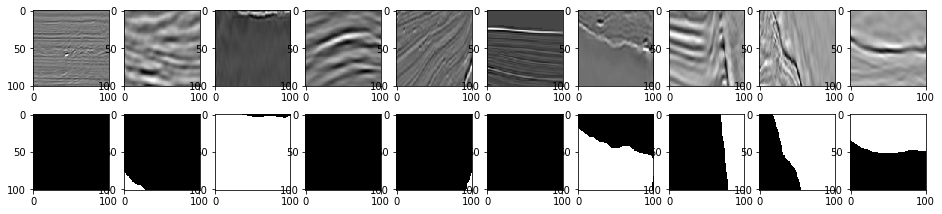

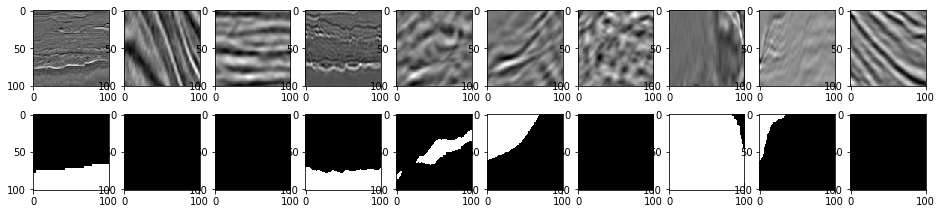

In [28]:
plt.figure(figsize=(16,3.5))
num_images = 10
for i in range(num_images):
    curr_image = skimage.io.imread(traindir + 'images/' + train_image_files[i])
    curr_mask  = skimage.io.imread(traindir + 'masks/'  + train_mask_files[i])
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,3.5))
for i in range(num_images,2*num_images):
    curr_image = skimage.io.imread(traindir + 'images/' + train_image_files[i])
    curr_mask  = skimage.io.imread(traindir + 'masks/'  + train_mask_files[i])
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

In [29]:
image1.sum()

3708138

In [23]:
images = np.array([skimage.io.imread(traindir + 'images/' + x, grayscale=True) for x in train_image_files])

In [24]:
masks = np.array([skimage.io.imread(traindir + 'masks/' + x, grayscale=True) for x in train_mask_files])

In [32]:
images.shape

(4000, 101, 101, 3)

In [33]:
"kdkf/iwitl".split("/")

['kdkf', 'iwitl']

In [34]:
sums = images.sum(axis=(1,2,3))
avgs = images.mean(axis=(1,2,3))
maxs = images.max(axis=(1,2,3))
mins = images.min(axis=(1,2,3))

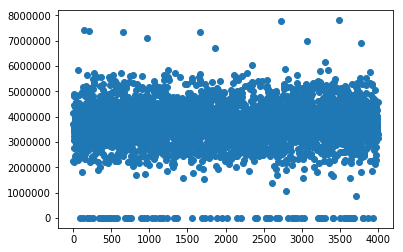

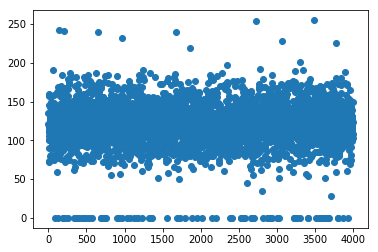

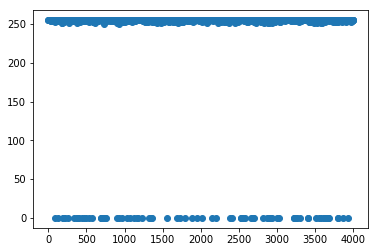

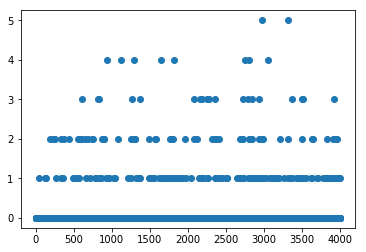

In [35]:
plt.plot(sums, 'o'); plt.show()
plt.plot(avgs, 'o'); plt.show()
plt.plot(maxs, 'o'); plt.show()
plt.plot(mins, 'o'); plt.show()

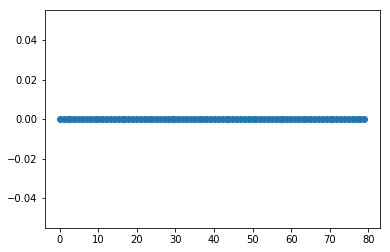

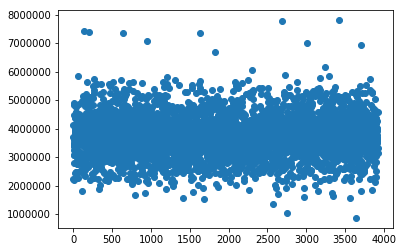

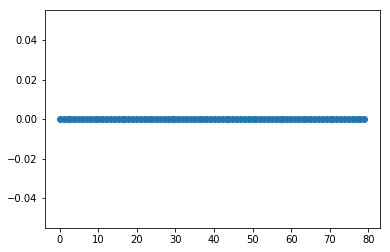

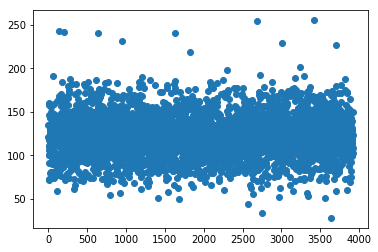

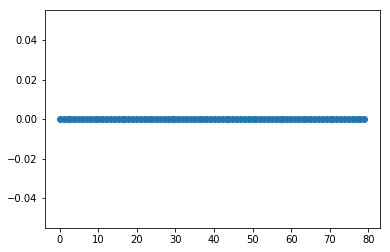

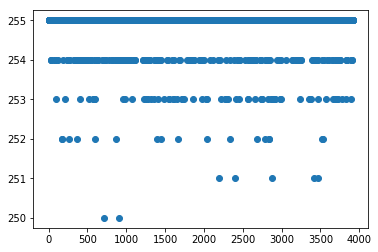

In [36]:
plt.plot(sums[sums < 1000], 'o'); plt.show()
plt.plot(sums[sums >= 1000], 'o'); plt.show()

plt.plot(avgs[avgs < 5], 'o'); plt.show()
plt.plot(avgs[avgs >= 5], 'o'); plt.show()

plt.plot(maxs[maxs < 5], 'o'); plt.show()
plt.plot(maxs[maxs >= 5], 'o'); plt.show()

In [37]:
len(sums[sums < 1000])

80

In [38]:
np.argwhere(sums < 1000).reshape(-1)

array([  90,  127,  186,  197,  217,  263,  336,  379,  380,  408,  437,
        470,  499,  536,  579,  685,  686,  710,  729,  742,  753,  895,
        924,  973, 1032, 1078, 1130, 1158, 1177, 1231, 1320, 1351, 1360,
       1556, 1691, 1727, 1792, 1883, 1951, 2018, 2154, 2197, 2389, 2409,
       2530, 2534, 2560, 2586, 2664, 2690, 2704, 2821, 2873, 2900, 2912,
       2944, 2998, 3032, 3221, 3225, 3252, 3265, 3309, 3410, 3412, 3510,
       3561, 3582, 3615, 3618, 3629, 3656, 3663, 3675, 3679, 3683, 3809,
       3811, 3874, 3936])

So all these arrays are bad. Let's double check that the other attributes overlap (sum, avg, min). Don't do min, there could legitimately be an image where the minimum value is 0.

In [67]:
bad_sum_indx = list(np.argwhere(sums < 1000).reshape(-1))
bad_avg_indx = list(np.argwhere(avgs < 5).reshape(-1))
bad_max_indx = list(np.argwhere(maxs < 5).reshape(-1))

In [72]:
print set(bad_sum_indx) - set(bad_sum_indx).intersection(set(bad_avg_indx))
print set(bad_sum_indx) - set(bad_sum_indx).intersection(set(bad_max_indx))

set([])
set([])


In [78]:
np.unique(images[bad_sum_indx])
np.unique(images[bad_avg_indx])
np.unique(images[bad_max_indx])

array([0], dtype=uint8)

Cool, so nothing cray is going on. That's good to know.

In [73]:
bad_indx = list(np.argwhere(sums < 1000).reshape(-1))

In [76]:
np.unique(masks[bad_indx])

array([0], dtype=uint16)

OK, so these masks are also bad. That's also good to double check. So we are going to have to take these out of our training set, unless we are looking to purposefully mess up our training for absolutely no reason.

Let's check out the depths, see if we can find any correlation. We will still need to include it as a feature I think, because it could still be affecting things we can't see in these simple correlation plots.

In [79]:
depths = pd.read_csv('../depths.csv')

In [80]:
depths.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [87]:
statsdf = pd.DataFrame(map(lambda x: x.split('.')[0],train_image_files), columns=['id'])

In [89]:
statsdf = pd.merge(statsdf, depths, on='id')

In [111]:
statsdf.shape

(4000, 10)

In [94]:
sums_masks = masks.sum(axis=(1,2))
avgs_masks = masks.mean(axis=(1,2))
maxs_masks = masks.max(axis=(1,2))
mins_masks = masks.min(axis=(1,2))

In [95]:
statsdf['sums'] = sums
statsdf['avgs'] = avgs
statsdf['maxs'] = maxs
statsdf['mins'] = mins

statsdf['sums_masks'] = sums_masks
statsdf['avgs_masks'] = avgs_masks
statsdf['maxs_masks'] = maxs_masks
statsdf['mins_masks'] = mins_masks

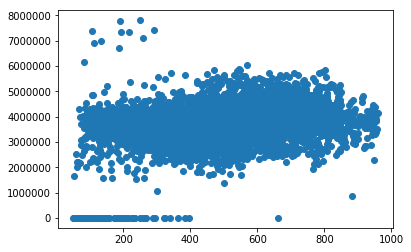

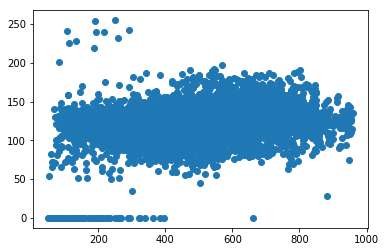

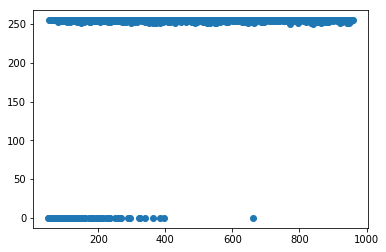

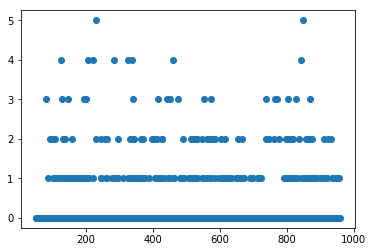

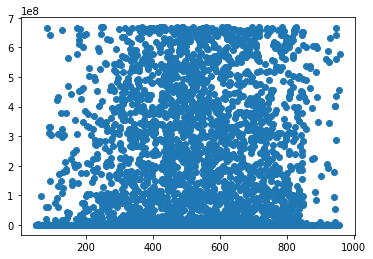

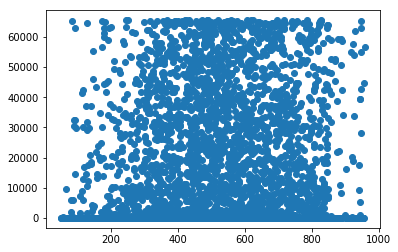

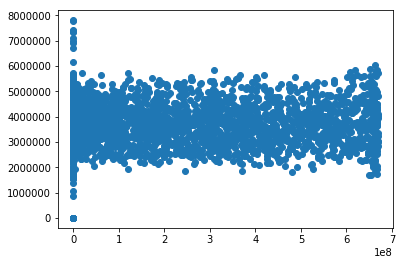

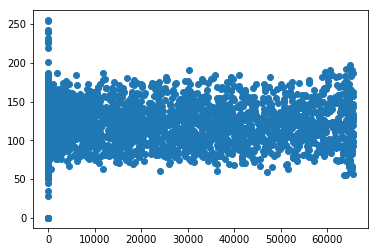

In [99]:
plt.plot(statsdf['z'], statsdf['sums'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['avgs'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['maxs'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['mins'],'o'); plt.show()

plt.plot(statsdf['z'], statsdf['sums_masks'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['avgs_masks'],'o'); plt.show()
# plt.plot(statsdf['z'], statsdf['maxs_masks'],'o'); plt.show()
# plt.plot(statsdf['z'], statsdf['mins_masks'],'o'); plt.show()

plt.plot(statsdf['sums_masks'], statsdf['sums'],'o'); plt.show()
plt.plot(statsdf['avgs_masks'], statsdf['avgs'],'o'); plt.show()


### Let's take a look at the test data, are we going to run into those weird examples in the test data?

In [103]:
testdir = '../test/'

test_image_files = os.listdir(filter_directory_list(testdir + 'images/'))

In [107]:
test_images = np.array([skimage.io.imread(testdir + 'images/' + x) for x in test_image_files])

In [108]:
test_images.shape

(18000, 101, 101, 3)

In [109]:
test_sums = test_images.sum(axis=(1,2,3))
test_avgs = test_images.mean(axis=(1,2,3))
test_maxs = test_images.max(axis=(1,2,3))
test_mins = test_images.min(axis=(1,2,3))

In [110]:
depths.shape

(22000, 2)

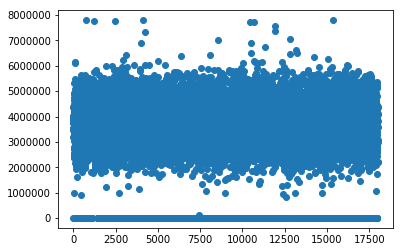

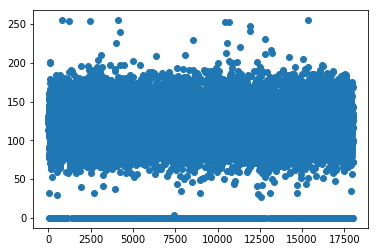

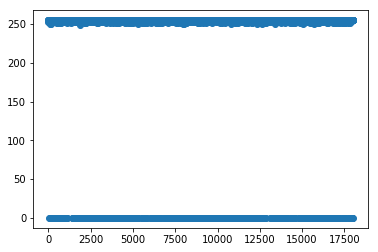

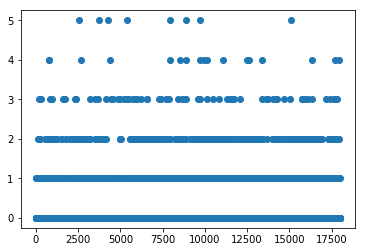

In [112]:
plt.plot(test_sums, 'o'); plt.show()
plt.plot(test_avgs, 'o'); plt.show()
plt.plot(test_maxs, 'o'); plt.show()
plt.plot(test_mins, 'o'); plt.show()

So we are going to have to deal with this as well. In the end, I believe for our training set we will also want to correlate our IOU vs. sum. Obviously we will eliminate any blanks in training. Then we can look at how well we do vs. the sum value, my guess is that those outliers that we see in the training set we will do badly on. It may be that we have to do something clever for them. But I guess let's not solve that problem until we come to it.

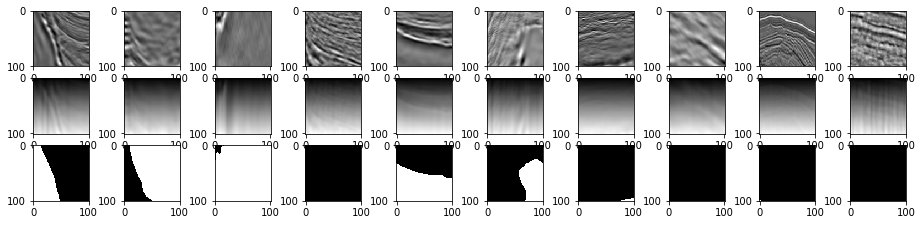

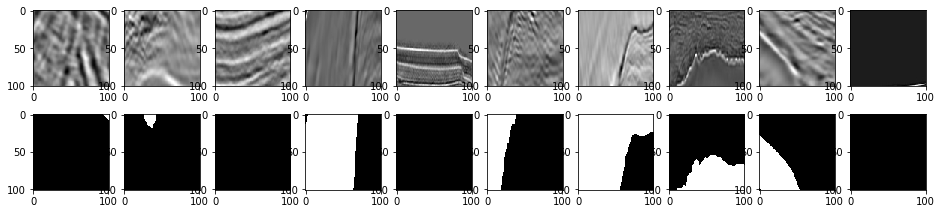

In [41]:
plt.figure(figsize=(16,3.5))
num_images = 10
for i in range(num_images):
    curr_image = images[i]
    curr_mask  = masks[i]
    
    plt.subplot(3,num_images,i+1); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(3,num_images,num_images + i + 1); 
    plt.imshow(curr_image.cumsum(axis=0), cmap='gray')
    
    plt.subplot(3,num_images,2*num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,3.5))
for i in range(num_images,2*num_images):
    curr_image = images[i]
    curr_mask  = masks[i]
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

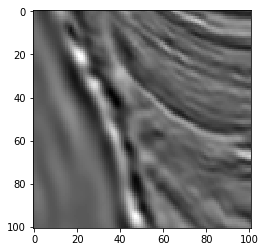

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


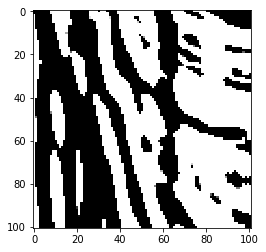

In [21]:
plt.imshow(images[0]); plt.show()
plt.imshow((images[0]-images[0].mean()).cumsum(axis=0), cmap='seismic')

In [ ]:
(images[0]-images[0].mean()).cumsum(axis=0)

In [27]:
images = np.array([skimage.io.imread(traindir + 'images/' + x, as_grey=True) for x in train_image_files])

In [28]:
img = images[0]-images[0].mean()
img.shape

(101, 101)

In [30]:
img.min()

-0.3805120989676137

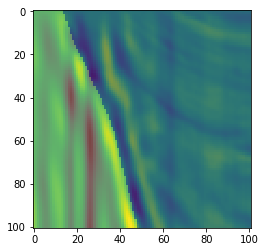

In [36]:
plt.imshow(img.cumsum(axis=0))
plt.imshow(masks[0],alpha=0.3)

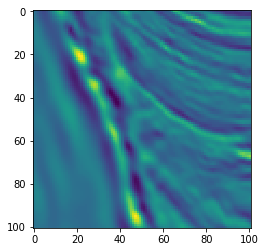

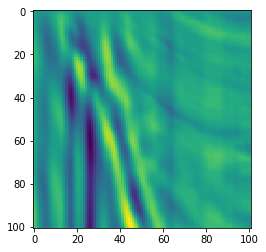

In [39]:
plt.imshow(img); plt.show()
plt.imshow(img.cumsum(axis=0))
# plt.imshow(masks[0],alpha=0.3)